scanpy==1.4.6.dev9+ge632939 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1
scanpy==1.4.6.dev9+ge632939 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


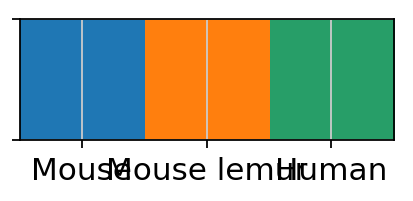

In [1]:
from collections import defaultdict
import glob
import os

import anndata
import pandas as pd
import numpy as np
import scanpy
import scanpy as sc

import xspecies

scanpy.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
scanpy.logging.print_versions()
scanpy.set_figure_params(frameon=False, color_map='magma_r')

# Define outdirs

In [2]:
outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/data/cross-species/within-species-de'
outdir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/within-species-de'
! mkdir $outdir_gdrive $outdir_local
outdirs = outdir_local, outdir_gdrive
!ls -lha $outdir_local

mkdir: cannot create directory ‘/home/olga/googledrive/TabulaMicrocebus/data/cross-species/within-species-de’: File exists
mkdir: cannot create directory ‘/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/within-species-de’: File exists
total 27G
drwxr-xr-x  2 olga czb 4.0K May 24 09:47 .
drwxrwxr-x 13 olga czb 8.0K May 22 13:37 ..
-rw-r--r--  1 olga czb 5.7G May 24 09:35 human_lung__diffexpr_broad_group__defaults.h5ad
-rw-r--r--  1 olga czb 5.7G May 24 09:48 human_lung__diffexpr_compartment_group__defaults.h5ad
-rw-r--r--  1 olga czb 5.7G May 24 09:31 human_lung__diffexpr_narrow_group__defaults.h5ad
-rw-r--r--  1 olga czb 5.7G May 24 09:26 human_lung_from_hlca__unified_compartments.h5ad
-rw-r--r--  1 olga czb 432M May 24 09:26 lemur_lung__diffexpr_broad_group__defaults.h5ad
-rw-r--r--  1 olga czb 432M May 24 09:27 lemur_lung__diffexpr_compartment_group__defaults.h5ad
-rw-r--r--  1 olga czb 553M May 22 15:58 lemur_lung__diffexpr_compartment_group.h5ad
-rw-r--

# Iterate over h5ads

In [3]:
adatas = defaultdict(dict)


for h5ad in glob.glob(f'{outdir_local}/*diffexpr*defaults.h5ad'):
    basename = os.path.basename(h5ad)
    split = basename.split('__')
    species = split[0].split('_')[0]
    group = split[1].split('_')[1]
    print(basename)
    print(f"group: {group}")
    print(f"species: {species}")
        
    ad = sc.read(h5ad, cache=True)
    adatas[group][species] = ad


mouse_lung__diffexpr_compartment_group__defaults.h5ad
group: compartment
species: mouse
human_lung__diffexpr_broad_group__defaults.h5ad
group: broad
species: human
mouse_lung__diffexpr_broad_group__defaults.h5ad
group: broad
species: mouse
mouse_lung__diffexpr_narrow_group__defaults.h5ad
group: narrow
species: mouse
lemur_lung__diffexpr_narrow_group__defaults.h5ad
group: narrow
species: lemur
human_lung__diffexpr_narrow_group__defaults.h5ad
group: narrow
species: human
lemur_lung__diffexpr_broad_group__defaults.h5ad
group: broad
species: lemur
lemur_lung__diffexpr_compartment_group__defaults.h5ad
group: compartment
species: lemur
human_lung__diffexpr_compartment_group__defaults.h5ad
group: compartment
species: human


## Create per-group species aggregated

In [11]:
import xspecies

class XspeciesAdatas:
    def __init__(self, group, human=None, mouse=None, lemur=None):
        self.group = group
        self.human = human
        self.mouse = mouse
        self.lemur = lemur
        
        self.adatas = {'human': self.human, 'mouse': self.mouse, 'lemur': self.lemur}
        
        self.de_results = self.aggregate_de_results()

        
    @staticmethod 
    def _single_adata_get_de_single_result(adata, result):
        if result == 'names':
            name = 'gene_name'
            extractor = xspecies.CrossSpeciesComparison.extract_de_names
        elif result == 'scores':
            name = 'de_score'
            extractor = xspecies.CrossSpeciesComparison.extract_de_scores
        elif result == 'logfoldchanges':
            name = 'de_logfoldchange'
            extractor = xspecies.CrossSpeciesComparison.extract_de_logfoldchanges
        elif result == 'pvals':
            name = 'de_pval_adj'
            extractor = xspecies.CrossSpeciesComparison.extract_de_pvals_adj
        else:
            raise ValueError(f"{result} is not a valid result name")
        results = extractor(adata).unstack()
        results.name = name
        results = results.to_frame()
        return results
    
    def _single_adata_get_de_results(self, adata, species, result_names=('names', 'scores', 'pvals', 'logfoldchanges')):

        dfs = []

        for name in result_names:
            df = self._single_adata_get_de_single_result(adata, name)
            dfs.append(df)
            
        # Column bind, because the row names (index) are shared
        de_results = pd.concat(dfs, axis=1)
        de_results = de_results.reset_index()
        de_results = de_results.rename(columns={'level_0': group, 'level_1': 'de_rank'})
        de_results['species'] = species
#         de_results.head()
        return de_results

    def aggregate_de_results(self):
        dfs = []
        
        for species, adata in self.adatas.items():
            if adata is None:
                print(f'{species} has no adata - skipping')
                continue
            df = self._single_adata_get_de_results(adata, species)
            dfs.append(df)
            
        # Row bind because columns are shared
        de_results = pd.concat(dfs)
        return de_results

        
group = 'compartment'
compartment = XspeciesAdatas(group, **adatas[group])
compartment.de_results.head()

,compartment,de_rank,gene_name,de_score,de_pval_adj,de_logfoldchange,species
0,endothelial,0,RAMP2,144.976913,0.0,15.056751,human
1,endothelial,1,CLDN5,122.731155,0.0,26.642111,human
2,endothelial,2,SDPR,120.036957,0.0,12.010092,human
3,endothelial,3,EGFL7,118.039703,0.0,8.187877,human
4,endothelial,4,GNG11,116.022957,0.0,10.227031,human


In [23]:
adatas['broad']

{'human': AnnData object with n_obs × n_vars = 57353 × 26485 
     obs: 'nGene', 'nUMI', 'orig.ident', 'channel', 'tissue', 'region', 'percent.ribo', 'free_annotation', 'patient', 'sample', 'location', 'magnetic.selection', 'preparation.site', 'compartment', 'species', 'species_latin', 'cell_ontology_class', 'narrow_group', 'broad_group', 'compartment_group'
     uns: 'rank_genes_groups',
 'mouse': AnnData object with n_obs × n_vars = 23802 × 20138 
     obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'species', 'species_latin', 'channel', 'channel_tissue', 'sequencing_run', 'cell_barcode', 'n_barcodes', 'narrow_group', 'broad_group', 'compartment_group'
     var: 'n_cells'
     uns: 'rank_genes_groups',
 'lemur': AnnData object with n_obs × n_vars = 36933 × 31509 
     obs: 'batch', 'channel', 'individual', 'method', 'original_channel', 'channel_no_10x', 'sequenci

In [24]:
df = compartment.de_results.query('compartment == "endothelial"')
df.head()

,compartment,de_rank,gene_name,de_score,de_pval_adj,de_logfoldchange,species
0,endothelial,0,RAMP2,144.976913,0.0,15.056751,human
1,endothelial,1,CLDN5,122.731155,0.0,26.642111,human
2,endothelial,2,SDPR,120.036957,0.0,12.010092,human
3,endothelial,3,EGFL7,118.039703,0.0,8.187877,human
4,endothelial,4,GNG11,116.022957,0.0,10.227031,human


In [25]:
df.pivot_table(columns='species', index='de_rank', values=['gene_name'], observed=False, aggfunc=lambda x: x)

gene_name                       
species     human         lemur    mouse
de_rank                                 
0           RAMP2         RAMP2  Tmem100
1           CLDN5         EGFL7    Egfl7
2            SDPR         NPDC1   Tspan7
3           EGFL7         ECSCR    Ramp2
4           GNG11          ESAM    Cldn5
...           ...           ...      ...
95          MYZAP  LOC109731207     Rhoj
96          MYCT1         HTR2B    Clic4
97        TSPAN12      SERPINH1     Nkd1
98        RAPGEF5        ADGRL2    Spnb2
99            TEK  LOC105882989   Clec2d

[100 rows x 3 columns]

In [26]:
def pivot_by_species(df):
    pivoted = df.pivot_table(columns='species', index='de_rank', 
                             values=['gene_name', 'de_score', 'de_pval_adj', 'de_logfoldchange'], 
                             aggfunc=lambda x: x)
    return pivoted

## Write aggregated results to excel

In [27]:
with pd.ExcelWriter(f"{outdir_gdrive}/across_species_{compartment.group}.xlsx") as writer:
    for name, df in compartment.de_results.groupby(compartment.group):
        pivoted = pivot_by_species(df)
        pivoted.to_excel(writer, sheet_name=name)

# Iterate over all compartments and make all fiels

In [28]:
for group, ads in adatas.items():
    print(f'-- {group} --')
    print(ads)
    group_xspecies = XspeciesAdatas(group, **ads)
    xlsx = f"{outdir_gdrive}/across_species_{group_xspecies.group}.xlsx"
    with pd.ExcelWriter(xlsx) as writer:
        for name, df in group_xspecies.de_results.groupby(group_xspecies.group):
            name_cleaned = name.replace('/', '-slash-')
            pivoted = pivot_by_species(df)
            pivoted.to_excel(writer, sheet_name=name_cleaned)
    print(f"\tWrote {xlsx}")

-- compartment --
{'mouse': AnnData object with n_obs × n_vars = 23802 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'species', 'species_latin', 'channel', 'channel_tissue', 'sequencing_run', 'cell_barcode', 'n_barcodes', 'narrow_group', 'broad_group', 'compartment_group'
    var: 'n_cells'
    uns: 'rank_genes_groups', 'lemur': AnnData object with n_obs × n_vars = 36933 × 31509 
    obs: 'batch', 'channel', 'individual', 'method', 'original_channel', 'channel_no_10x', 'sequencing_run', 'free_annotation', 'tissue', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'compartment_id', 'n_genes', 'n_counts', 'narrow_group', 'broad_group', 'compartment_group'
    var: 'gene_ids'
    uns: 'rank_genes_groups', 'human': AnnData object with n_obs × n_vars = 57353 × 26485 
    obs: 'nGene', 'nUMI', 'orig.ident', 'channel', 'tissue', 'region', 'percent.